<a href="https://colab.research.google.com/github/HHIR/HumanPoseClassification-fastai/blob/master/HumanPoseClassification-Fastai%20%26PyTorch_v1_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a Google Colab notebook which installs appropriate PyTorch v1 according to the system architecture and the GPU available.

If you come across any issues, then feel free to contact me on Slack. My username is ***avinashss***


In [1]:
# google colab does not come with torch installed. And also, in lesson we are 
# using torch v1.0 
# so following snippet of code installs the relevant version according to the 
# GPU architecture
!pip install -q torch==1.0.0 torchvision

     |████████████████████████████████| 591.8MB 32kB/s 
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 1.0.0 which is incompatible.


In [2]:
import torch
print(torch.__version__)

1.0.0


In [3]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Converting to Torch Script via Tracing

In [0]:

import torch
import torchvision

# An instance of your model.
model = torchvision.models.resnet18()

# An example input you would normally provide to your model's forward() method.
example = torch.rand(1, 3, 224, 224)

# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(model, example)

# inspect traced_script_module variable
# print(traced_script_module)

In [5]:
output = traced_script_module(torch.ones(1, 3, 224, 224))
output[0, :5]

tensor([-0.1449, -1.1103, -0.0356,  0.1189,  0.0326], grad_fn=<SliceBackward>)

# Converting to Torch Script via Annotation


In [0]:
from fastai.vision import *

In [8]:
# Creating two directories - "data" and "data/trainset_11classes_0_00000" 
#!mkdir data && mkdir data/trainset_11classes_0_00000

# Downloading the ai-camp competition dataset
!wget -N http://hosseinhashemi.info/dataset/dsta_poses.zip
  
# Unzip the data into the folder "data/trainset_11classes_0_00000"
!unzip -qq -n dsta_poses.zip # -d data/trainset_11classes_0_00000

# Switch directory to "data/trainset_11classes_0_00000" and show its content
!cd dsta_poses && ls

--2019-10-19 23:04:42--  http://hosseinhashemi.info/dataset/dsta_poses.zip
Resolving hosseinhashemi.info (hosseinhashemi.info)... 62.212.88.246
Connecting to hosseinhashemi.info (hosseinhashemi.info)|62.212.88.246|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 507437943 (484M) [application/zip]
Saving to: ‘dsta_poses.zip’

dsta_poses.zip      100%[===================>] 483.93M  11.2MB/s    in 46s     

2019-10-19 23:05:29 (10.5 MB/s) - ‘dsta_poses.zip’ saved [507437943/507437943]

train  val


In [0]:
import os

base_dir = 'dsta_poses'

# Directory to our training data
train_folder = os.path.join(base_dir, 'train')

# Directory to our validation data
val_folder = os.path.join(base_dir, 'val')

In [10]:
# List folders and number of files
print("Directory, Number of files")
for root, subdirs, files in os.walk(base_dir):
    print(root, len(files))

Directory, Number of files
dsta_poses 0
dsta_poses/train 0
dsta_poses/train/HandGun 93
dsta_poses/train/KoreanHeart 87
dsta_poses/train/Salute 90
dsta_poses/train/HulkSmash 88
dsta_poses/train/KungfuCrane 88
dsta_poses/train/KungfuSalute 92
dsta_poses/train/ChildPose 81
dsta_poses/train/HandShake 83
dsta_poses/train/WarriorPose 93
dsta_poses/train/ChairPose 89
dsta_poses/train/Dabbing 89
dsta_poses/val 0
dsta_poses/val/HandGun 26
dsta_poses/val/KoreanHeart 22
dsta_poses/val/Salute 24
dsta_poses/val/HulkSmash 24
dsta_poses/val/KungfuCrane 21
dsta_poses/val/KungfuSalute 25
dsta_poses/val/ChildPose 22
dsta_poses/val/HandShake 21
dsta_poses/val/WarriorPose 22
dsta_poses/val/ChairPose 23
dsta_poses/val/Dabbing 23


In [0]:
np.random.seed(18)
data = ImageDataBunch.from_folder(base_dir, train='.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

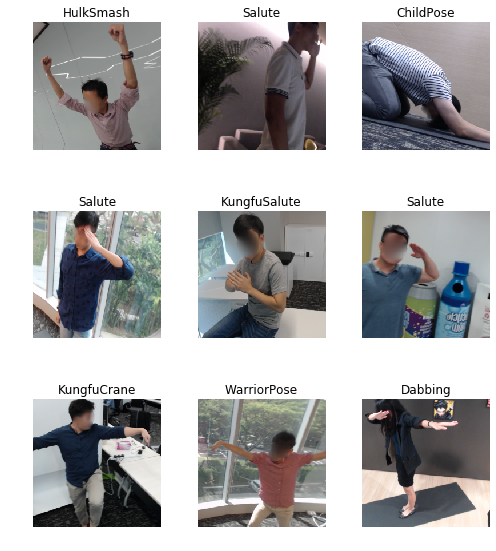

In [14]:
data.show_batch(rows=3, figsize=(7, 8))

In [15]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 51782800.87it/s]


In [16]:
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.724582,1.877840,0.636735,00:38
1,2.107643,1.344937,0.432653,00:37
2,1.693235,1.232191,0.391837,00:36
3,1.438368,1.209713,0.383673,00:36


In [0]:
learn.unfreeze() # must be done before calling lr_find

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


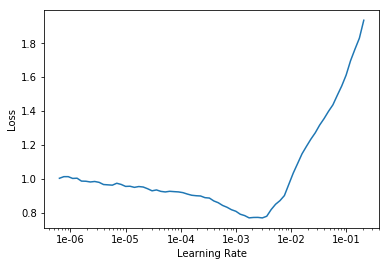

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(4, max_lr=slice(1e-04, 1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.888564,0.787697,0.257143,00:37
1,0.644767,0.567036,0.187755,00:36
2,0.489809,0.443939,0.151020,00:37
3,0.363505,0.403886,0.130612,00:37


In [0]:
learn.save('stage1')

In [0]:
from fastai.widgets import *

ds, idxs = DatasetFormatter().from_toplosses(learn)
ImageCleaner(ds, idxs, base_dir)

In [0]:
import pandas as pd

df = pd.read_csv('data/trainset_11classes_0_00000/cleaned.csv', header='infer')
print(df.head())

db = (ImageList.from_df(df, base_dir)
                   .random_split_by_pct(0.2)
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch(bs=8)).normalize(imagenet_stats)

In [0]:
print(data.classes, data.c, len(data.train_ds), len(data.valid_ds))
print(db.classes, db.c, len(db.train_ds), len(db.valid_ds))

In [0]:
db.show_batch()

In [0]:
learn.load('stage1') # loading the weights
learn.data = db # replacing the data

learn.freeze()
learn.fit_one_cycle(4)

learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

learn.fit_one_cycle(4, max_lr=slice(1e-04, 1e-03))
learn.save('stage2')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.plot_confusion_matrix()

In [0]:
interp.plot_top_losses(9, figsize=(15,15))